<a href="https://colab.research.google.com/github/zizilnam/Mini_Project_Machine_Learning_Elo_Merchant_Kaggle/blob/main/ELO_Merchant_EDA1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Elo Merchant Category Recommendation

https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo

이번 프로젝트의 목표는 고객 충성도를 알아내서 가장 연관성 높은 기회를 개인에게 제공하는 것입니다!

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

import datetime as dt
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment =None
pd.options.display.max_columns = 999

## Dataset Exploration
일단 어떤 파일들이 있는지 알아봅시다~

- train.csv - 트레이닝 세트
- test.csv - 테스트 세트
- sample_submission.csv - 옳은 포맷의 샘플 제출 파일(우리가 예측해야할 cards_ids가 포함 되어있다.)
- historical_transactions.csv - 3달치의 card_ids 별 거래 기록
- merchants.csv - 상인들의 merchant_ids 별 모든 추가적인 정보
- new_merchant_transactions.csv - 모든 card_ids의 historical_transactions에서 방문하지 않은 모든 구입들의 두달치 데이터


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/train.csv", parse_dates=["first_active_month"])
test_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/test.csv", parse_dates=["first_active_month"])
print("Number of rows and columns in train set : ", train_df.shape)
print("Number of rows and columns in test set : ", test_df.shape)

Number of rows and columns in train set :  (201917, 6)
Number of rows and columns in test set :  (123623, 5)


In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


Target Column Exploration

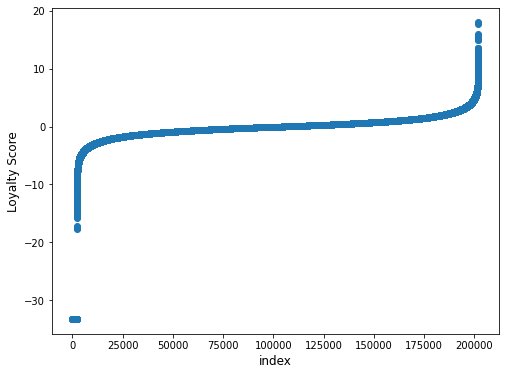

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df["target"].values))
plt.xlabel('index', fontsize=12)
plt.ylabel("Loyalty Score", fontsize=12)
plt.show()

<Figure size 864x1152 with 0 Axes>

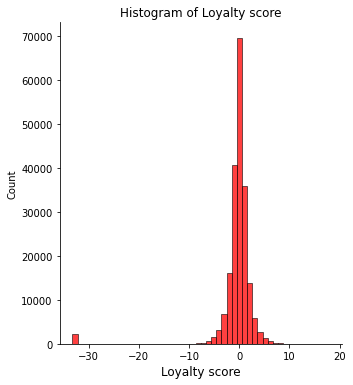

In [ ]:
plt.figure(figsize=(12,16))
sns.displot(train_df["target"].values, bins=50, kde=False, color="red")
plt.title("Histogram of Loyalty score")
plt.xlabel("Loyalty score", fontsize=12)
plt.show()

위의 그래프를 보면 -30 밑의 Loyalty score에 다른 데이터에 비해서 거리가 있는 데이터가 보입니다. 숫자를 세어볼까용?

In [ ]:
(train_df["target"]<-30).sum()

2207

2207개의 행이 나머지와 다른 성질을 보입니다. 그러므로 RMSE 평가시에 이 행들이 중요한 역할을 할 겁니다.

## First Active Month
테스트 세트와 트레인 세트의 카드별 First active month 데이터에서 분산 차이가 있는지 확인해봅시다. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



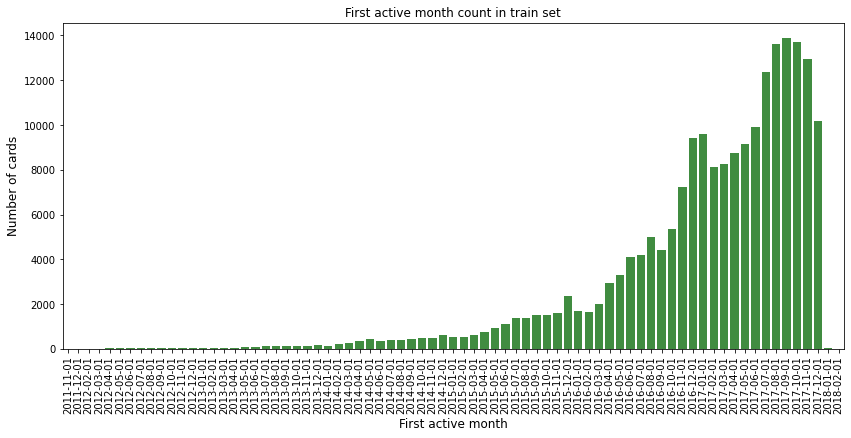

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



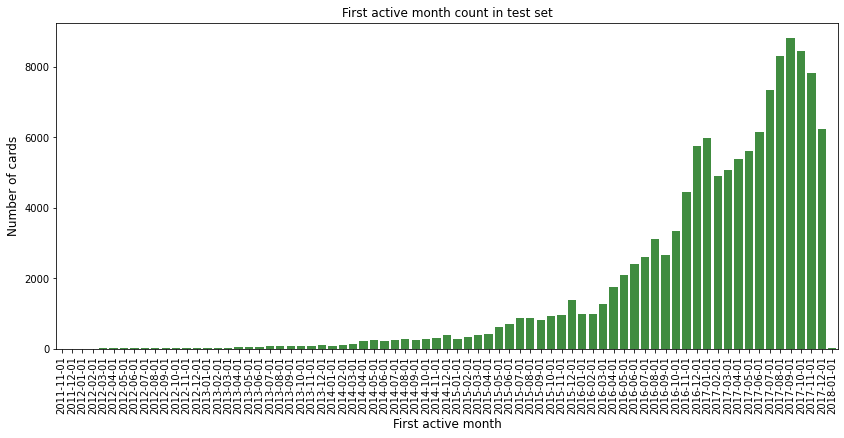

In [ ]:
cnt_srs = train_df["first_active_month"].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in train set')
plt.show()

cnt_srs = test_df['first_active_month'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('First active month', fontsize=12)
plt.ylabel('Number of cards', fontsize=12)
plt.title('First active month count in test set')
plt.show()

트레인과 테스트 셋의 그래프의 분포가 상당히 비슷한 걸 알 수 있습니다! 그러므로 시간에 기반한 데이터 분할은 필요 없어보입니다.

## Feature 1,2 & 3


트레인 데이터 셋에 있는 다른 변수들이 loyalty score를 찾을 때 좋은 예측력을 갖고 있는지 봅시다

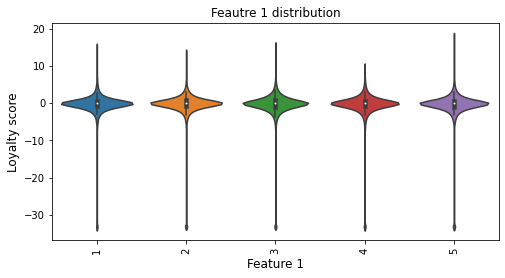

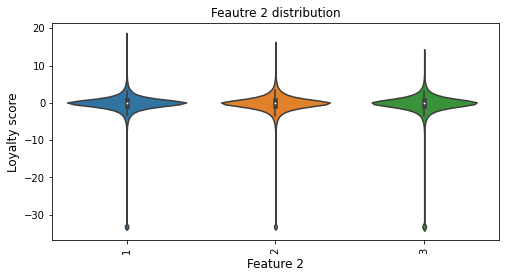

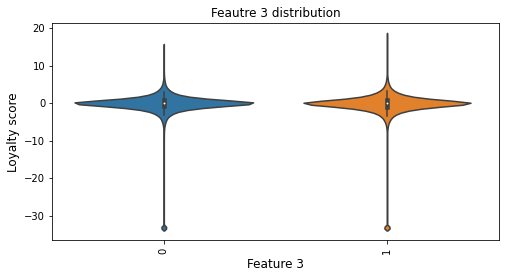

In [ ]:
#feature 1
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_1", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 1 distribution")
plt.show()

#feature 2
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_2", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 2', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 2 distribution")
plt.show()

#feature 3
plt.figure(figsize=(8,4))
sns.violinplot(x="feature_3", y="target", data=train_df)
plt.xticks(rotation='vertical')
plt.xlabel('Feature 3', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Feautre 3 distribution")
plt.show()

언뜻 보기에 카테고리별 분산이 다 비슷해 보입니다. 아마도 모델들로 무언가 알아낼 수 있을 것 같습니다.


## Historical Transactions
Historical transactions 데이터를 봅시다.

In [ ]:
hist_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/historical_transactions.csv")
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


- card_id - 카드 식별
- month_lag - 참고 날짜에서 월 지연 
- purchase_date - 구입 날짜
- authorized_flag - 승인 여부
- category_3 - 모름
- installments - 할부 개월 수
- category_1 - 모름
- merchant_category_id - 판매자 카테고리 id
- subsector_id - 판매자 카테고리 그룹 id
- merchant_id - 판맨자 id
- purchase_amount - normalize 된 판매량
- city_id - 도시 식별
- state_id - 주 식별
- category_2 - 모름

historical transactions의 feature와 트레인 데이터셋, 테스트데이터셋을 합쳐봅시다.

### Number of Historical Transactions for the card

In [ ]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_hist_transactions"]
train_df = pd.merge(train_df, gdf, on='card_id', how='left')
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

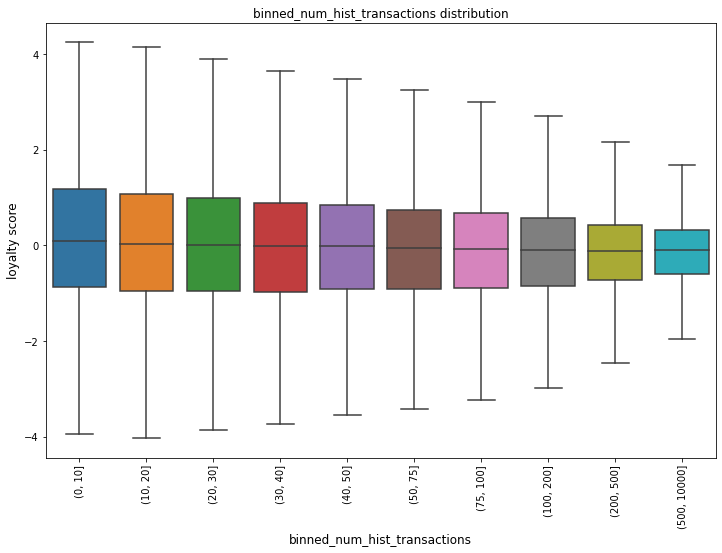

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 75, 100, 200, 500, 10000]
train_df['binned_num_hist_transactions'] = pd.cut(train_df['num_hist_transactions'], bins)
cnt_srs = train_df.groupby("binned_num_hist_transactions")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_hist_transactions", y= "target", data=train_df, showfliers = False)
plt.xticks(rotation='vertical')
plt.xlabel("binned_num_hist_transactions", fontsize=12)
plt.ylabel("loyalty score", fontsize=12)
plt.title("binned_num_hist_transactions distribution")
plt.show()

## Value of HIstorical Transactions
Now let us check the value of the historical transactions for the cards and check the loyalty score distribution based on that.

In [ ]:
gdf = hist_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns =["card_id", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041


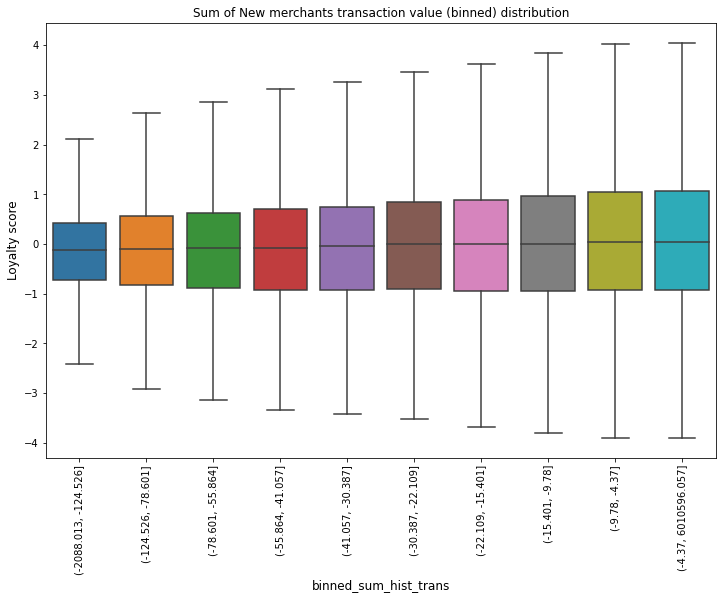

In [ ]:
bins= np.nanpercentile(train_df["sum_hist_trans"], range(0,101,10))
train_df["binned_sum_hist_trans"] = pd.cut(train_df["sum_hist_trans"], bins)
# cnt_srs = train_df.groupby("binned_sum_merch_trans")["target"].eman()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_hist_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation="vertical")
plt.xlabel('binned_sum_hist_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (binned) distribution")
plt.show()

Loyal score은 new merchant transaction value의 총합이 증가하면 같이 증가하면 같이 증가하는 걸로 보입니다. 마지막 bin만 뺴고

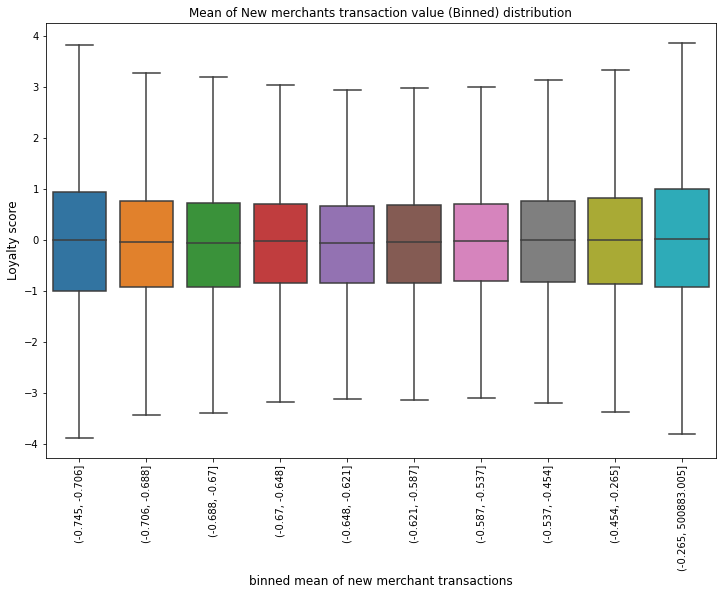

In [ ]:
bins = np.nanpercentile(train_df["mean_hist_trans"], range(0,101,10))
train_df['binned_mean_hist_trans'] = pd.cut(train_df['mean_hist_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_hist_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Mean of New merchants transaction value (Binned) distribution")
plt.show()

## New Merchant Transactions
new merchant transactions 데이터 분석

In [ ]:
new_trans_df = pd.read_csv("/content/drive/MyDrive/KDT/모델링 프로젝트/data/new_merchant_transactions.csv")
new_trans_df

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963026,Y,C_ID_1320dee851,142,N,0,A,309,M_ID_7754b67f3b,2,-0.701828,2018-04-06 14:36:52,3.0,19,21
1963027,Y,C_ID_f112aa3381,158,N,0,A,560,M_ID_da063195b7,2,-0.694390,2018-03-07 13:19:18,1.0,15,34
1963028,Y,C_ID_bd97b86450,69,N,1,B,278,M_ID_9a9ccb6544,1,-0.621031,2018-03-05 12:04:56,1.0,9,37
1963029,Y,C_ID_c0513fd84f,130,N,0,A,367,M_ID_40c28d596f,1,-0.656749,2018-03-09 14:47:05,3.0,7,16


In [ ]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].size().reset_index()
gdf.columns = ["card_id", "num_merch_transactions"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

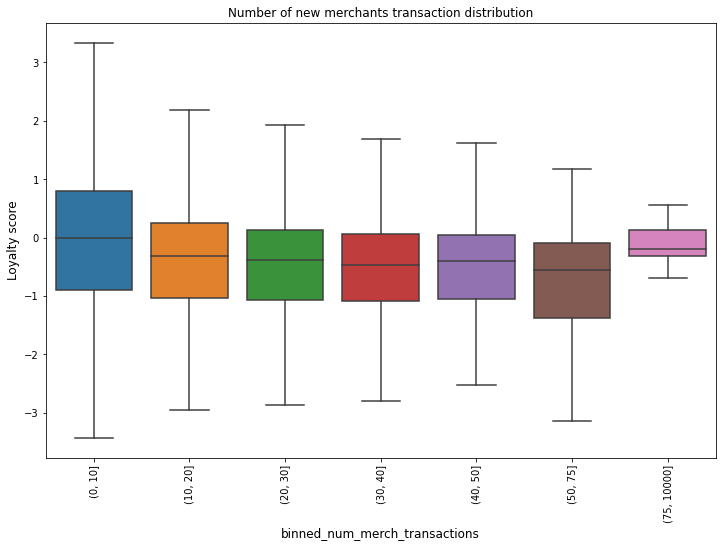

In [ ]:
bins = [0, 10, 20, 30, 40, 50, 75, 10000]
train_df['binned_num_merch_transactions'] = pd.cut(train_df['num_merch_transactions'], bins)
#cnt_srs = train_df.groupby("binned_num_merch_transactions")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_num_merch_transactions", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_num_merch_transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title('Number of new merchants transaction distribution')
plt.show()

Loyalty score은 마지막 것을 제외하고는 new merchant transactions가 증가할수록 감소합니다.

In [ ]:
gdf = new_trans_df.groupby("card_id")
gdf = gdf["purchase_amount"].agg(['sum', 'mean', 'std', 'min', 'max']).reset_index()
gdf.columns = ["card_id", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]
train_df = pd.merge(train_df, gdf, on="card_id", how="left")
test_df = pd.merge(test_df, gdf, on="card_id", how="left")

In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395,"(-2088.013, -124.526]","(-0.648, -0.621]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299,"(-2088.013, -124.526]","(-0.621, -0.587]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847,"(-30.387, -22.109]","(-0.688, -0.67]",1.0,"(0, 10]",-0.700326,-0.700326,NaN,-0.700326,-0.700326
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596,"(-55.864, -41.057]","(-0.648, -0.621]",7.0,"(0, 10]",-4.654372,-0.664910,0.065882,-0.734135,-0.566740
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041,"(-55.864, -41.057]","(-0.454, -0.265]",36.0,"(30, 40]",-19.926237,-0.553507,0.223821,-0.739395,0.450886


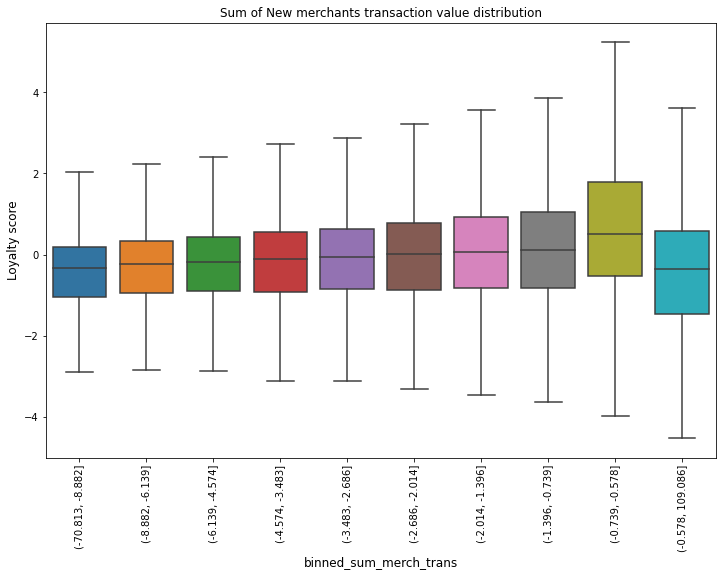

In [ ]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df["binned_sum_merch_trans"] = pd.cut(train_df['sum_merch_trans'], bins)
# cnt_srs = train_df.groupby("binned_sum_merch_trans")["target"].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y="target", data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned_sum_merch_trans', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value distribution")
plt.show()

Loyalty score은 마지막 bin을 제외하면 new merchant transactions의 value가 증가하면 함께증가하는 것을 알 수 있습니다.

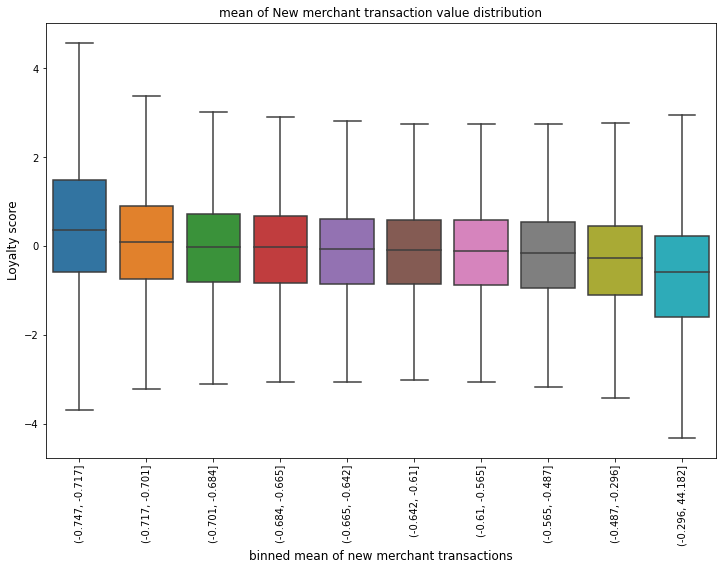

In [ ]:
bins = np.nanpercentile(train_df["mean_merch_trans"], range(0, 101, 10))
train_df["binned_mean_merch_trans"] = pd.cut(train_df['mean_merch_trans'], bins)

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_mean_merch_trans", y="target", data=train_df, showfliers= False)
plt.xticks(rotation='vertical')
plt.xlabel('binned mean of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("mean of New merchant transaction value distribution")
plt.show()

## Baseline Model
지금까지 만든 피쳐들로 baseline 모델을 만들어 봅시다.

In [ ]:
train_df["year"] = train_df["first_active_month"].dt.year
test_df["year"] = test_df["first_active_month"].dt.year
train_df["month"] = train_df["first_active_month"].dt.month
test_df["month"] = test_df["first_active_month"].dt.month

cols_to_use = ["feature_1", "feature_2", "feature_3", "year", "month", "num_hist_transactions", "sum_hist_trans", "mean_hist_trans", "std_hist_trans", "min_hist_trans", "max_hist_trans",
               "num_merch_transactions", "sum_merch_trans", "mean_merch_trans", "std_merch_trans", "min_merch_trans", "max_merch_trans"]



In [ ]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
  params = {
      "objective" : "regression",
      "metric" : "rmse",
      "num_leaves" :30,
      "min_child_weight" : 50,
      "learning_rate" : 0.05,
      "bagging_fraction" : 0.7,
      "feature_fraction" :0.7,
      "bagging_frequency" : 5,
      "baggin_seed" : 2018,
      "verbosity" : -1
  }

  lgtrain = lgb.Dataset(train_X, label=train_y)
  lgval = lgb.Dataset(val_X, label=val_y)
  evals_result = {}
  model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
  pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
  return pred_test_y, model, evals_result

train_X = train_df[cols_to_use]
test_X = test_df[cols_to_use]
train_y = train_df["target"].values

pred_test = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_df):
  dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
  dev_y, val_y = train_y[dev_index], train_y[val_index]

  pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
  pred_test += pred_test_tmp
pred_test /=5.

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.81049
[200]	valid_0's rmse: 3.80984
Early stopping, best iteration is:
[163]	valid_0's rmse: 3.80946
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.75935
[200]	valid_0's rmse: 3.75958
Early stopping, best iteration is:
[151]	valid_0's rmse: 3.75848
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.80311
[200]	valid_0's rmse: 3.80228
[300]	valid_0's rmse: 3.80269
Early stopping, best iteration is:
[210]	valid_0's rmse: 3.80206
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.7929
[200]	valid_0's rmse: 3.79349
Early stopping, best iteration is:
[145]	valid_0's rmse: 3.79269
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.8547
[200]	valid_0's rmse: 3.85516
Early stopping, best iteration is:
[127]	valid_0's rmse: 3.85456


In [ ]:
train_df.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,num_hist_transactions,binned_num_hist_transactions,sum_hist_trans,mean_hist_trans,std_hist_trans,min_hist_trans,max_hist_trans,binned_sum_hist_trans,binned_mean_hist_trans,num_merch_transactions,binned_num_merch_transactions,sum_merch_trans,mean_merch_trans,std_merch_trans,min_merch_trans,max_merch_trans,binned_sum_merch_trans,binned_mean_merch_trans,year,month
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,260,"(200, 500]",-165.968739,-0.638341,0.212139,-0.739395,2.258395,"(-2088.013, -124.526]","(-0.648, -0.621]",23.0,"(20, 30]",-13.244202,-0.575835,0.135812,-0.724368,-0.296112,"(-70.813, -8.882]","(-0.61, -0.565]",2017,6
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,350,"(200, 500]",-210.006336,-0.600018,0.384967,-0.742400,4.630299,"(-2088.013, -124.526]","(-0.621, -0.587]",6.0,"(0, 10]",-4.355735,-0.725956,0.014326,-0.739410,-0.701858,"(-4.574, -3.483]","(-0.747, -0.717]",2017,1
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,43,"(40, 50]",-29.167391,-0.678311,0.087380,-0.730138,-0.145847,"(-30.387, -22.109]","(-0.688, -0.67]",1.0,"(0, 10]",-0.700326,-0.700326,NaN,-0.700326,-0.700326,"(-0.739, -0.578]","(-0.701, -0.684]",2016,8
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,77,"(75, 100]",-49.491364,-0.642745,0.261624,-0.740897,1.445596,"(-55.864, -41.057]","(-0.648, -0.621]",7.0,"(0, 10]",-4.654372,-0.664910,0.065882,-0.734135,-0.566740,"(-6.139, -4.574]","(-0.665, -0.642]",2017,9
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,133,"(100, 200]",-48.687656,-0.366073,1.352094,-0.746156,7.193041,"(-55.864, -41.057]","(-0.454, -0.265]",36.0,"(30, 40]",-19.926237,-0.553507,0.223821,-0.739395,0.450886,"(-70.813, -8.882]","(-0.565, -0.487]",2017,11


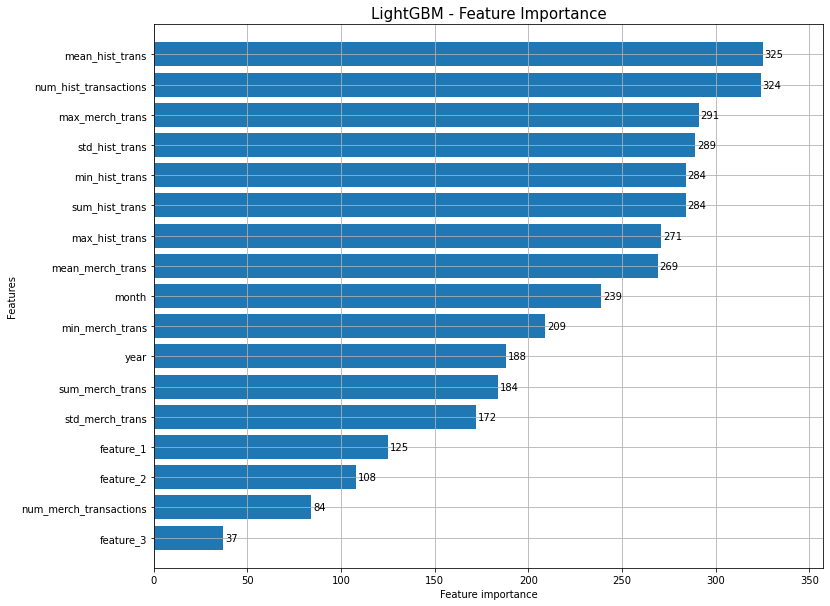

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(True)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()